In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-data-from-2010-to-2020/TSLA.csv


# **Import Libraries**

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import itertools
import warnings

warnings.filterwarnings("ignore")

2025-10-04 03:28:15.941708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759548496.113827      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759548496.162280      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ****Load Dataset****

In [4]:
df = pd.read_csv("/kaggle/input/tesla-stock-data-from-2010-to-2020/TSLA.csv")

# **Inspect Data**

In [5]:

print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
display(df.head())

Shape of dataset: (2416, 7)

Data Types:
 Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Missing Values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


# **Convert Date column to datetime & sort** 

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# **Descriptive Statistics**

In [7]:
display(df.describe(include='all'))


,Date,Open,High,Low,Close,Adj Close,Volume
count,2416,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,2015-04-15 11:09:56.026490112,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
min,2010-06-29 00:00:00,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,2012-11-19 18:00:00,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,2015-04-16 12:00:00,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,2017-09-07 06:00:00,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,2020-02-03 00:00:00,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07
std,NaN,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06


# **Plot Trends over Time**

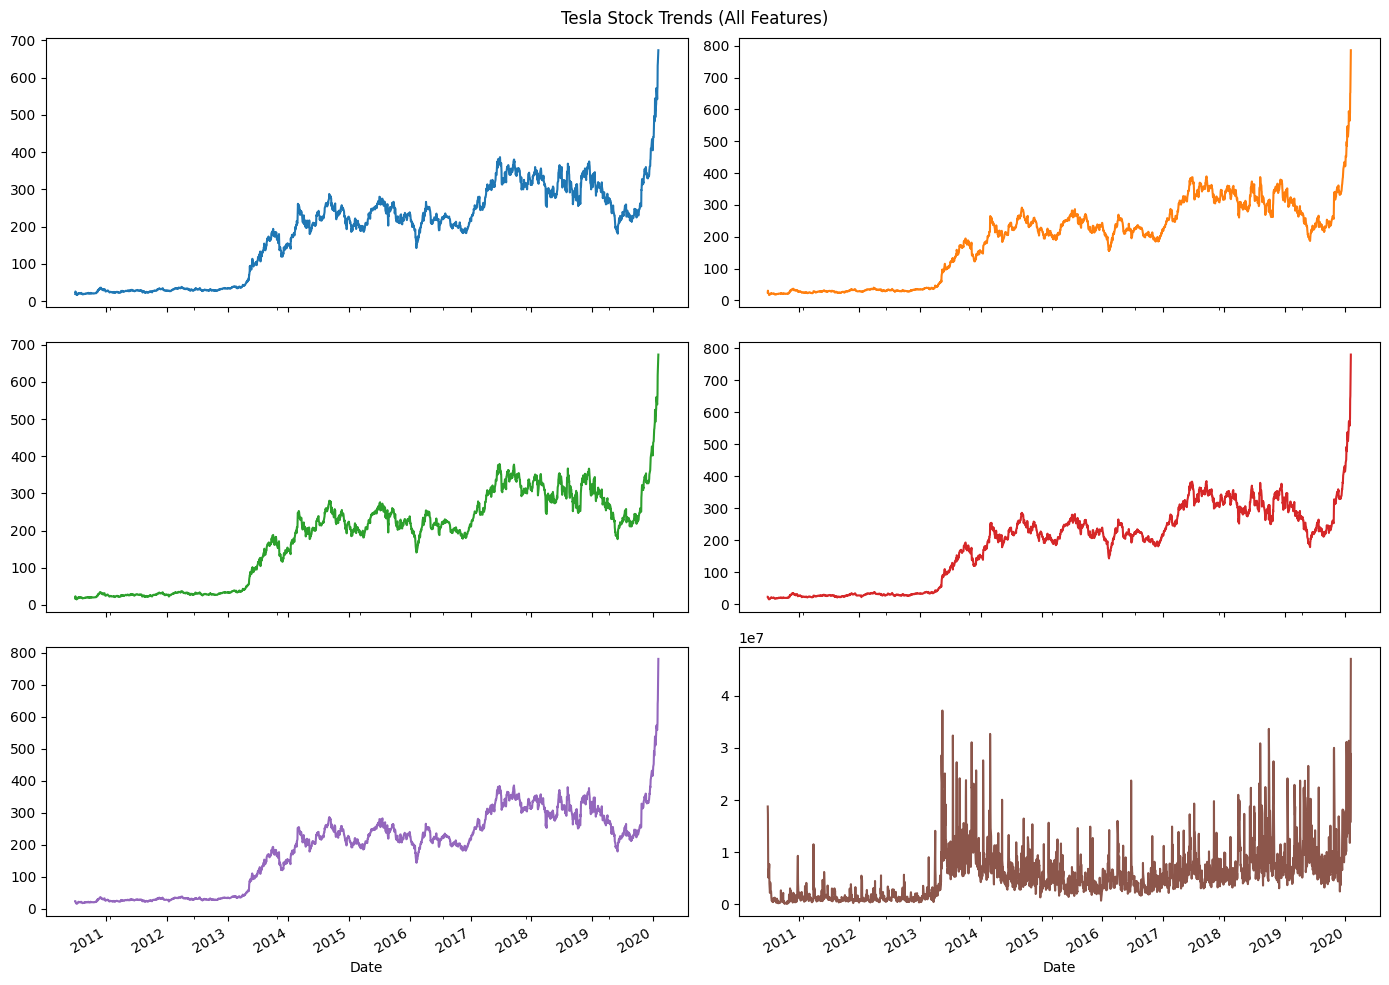

In [8]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df.plot(x="Date", y=cols, subplots=True, layout=(3, 2), figsize=(14,10), 
        title="Tesla Stock Trends (All Features)", legend=False)

plt.tight_layout()
plt.show()

# **Distribution of Features**

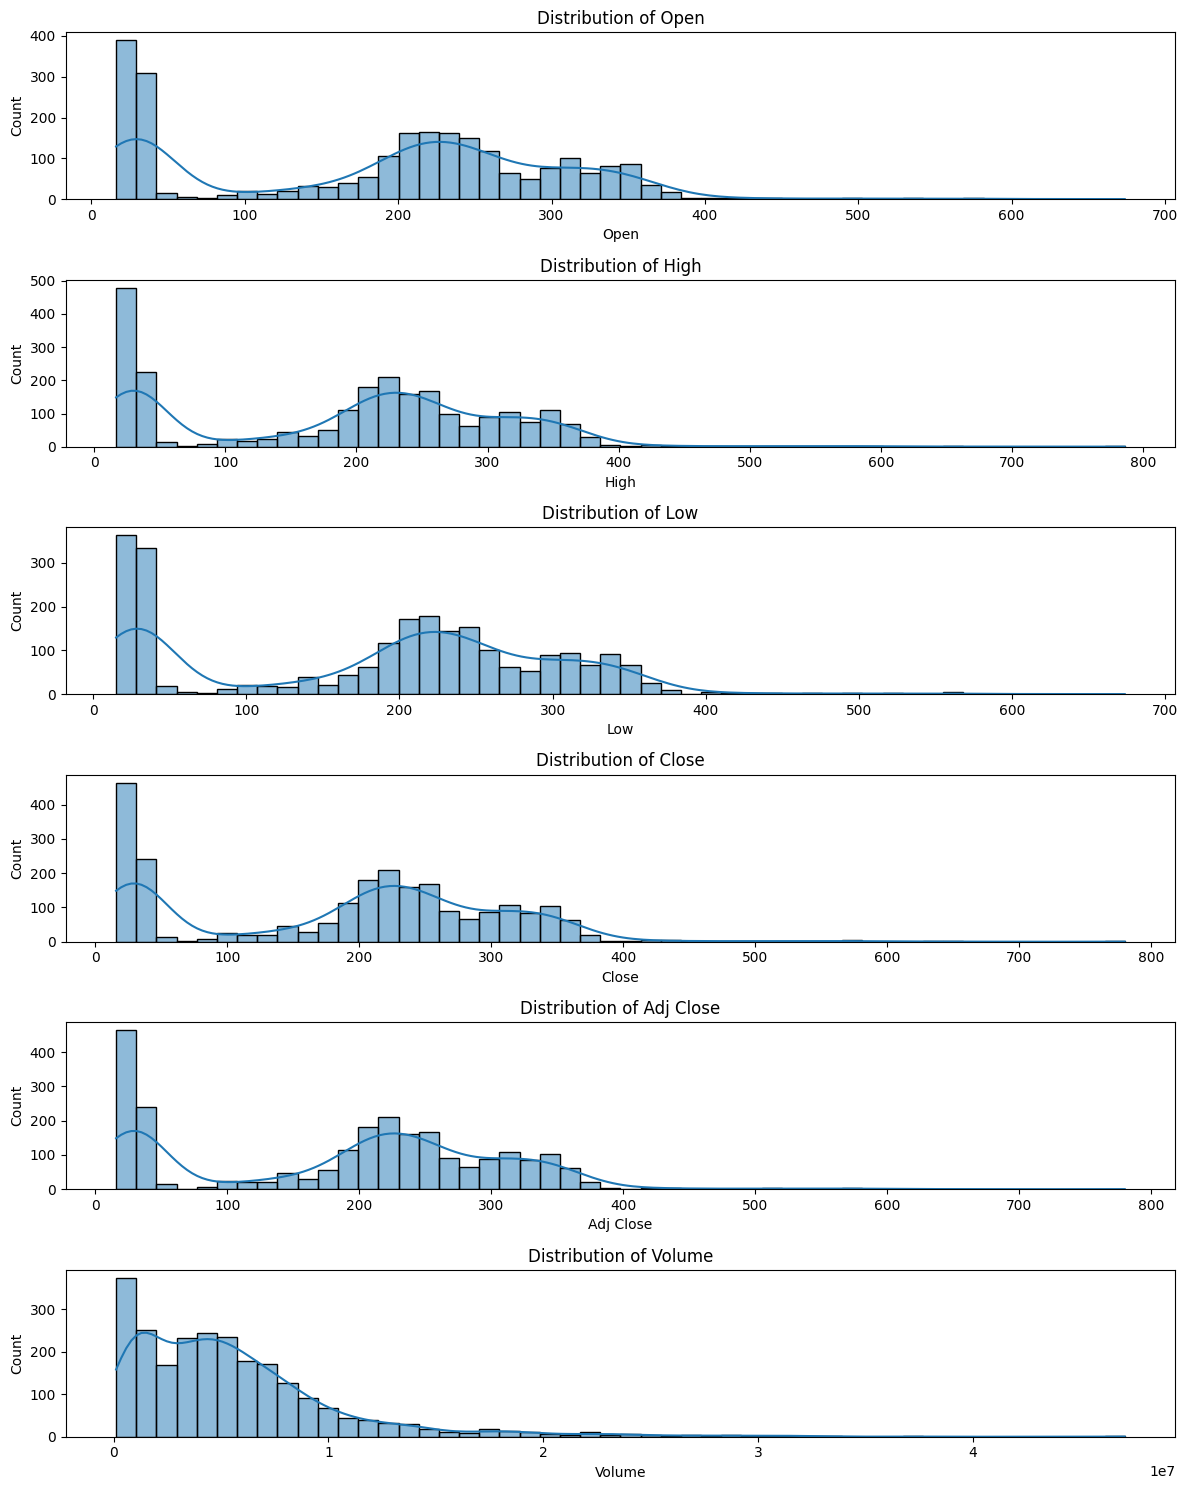

In [9]:
fig, axes = plt.subplots(len(cols), 1, figsize=(12,15))
for i, col in enumerate(cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# **Correlation Heatmap**

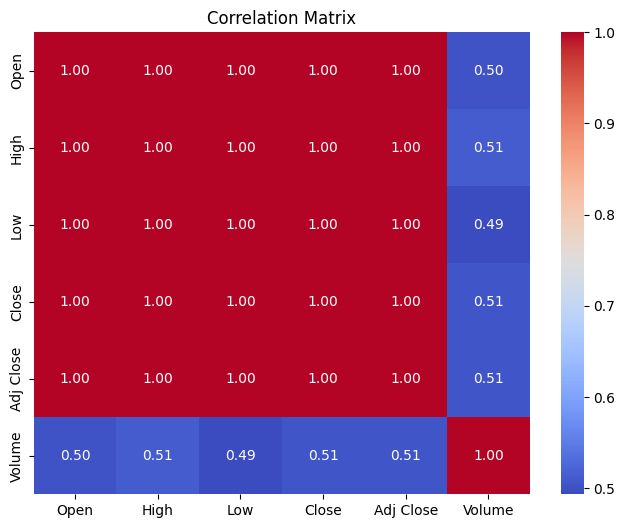

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# **Outlier Detection**

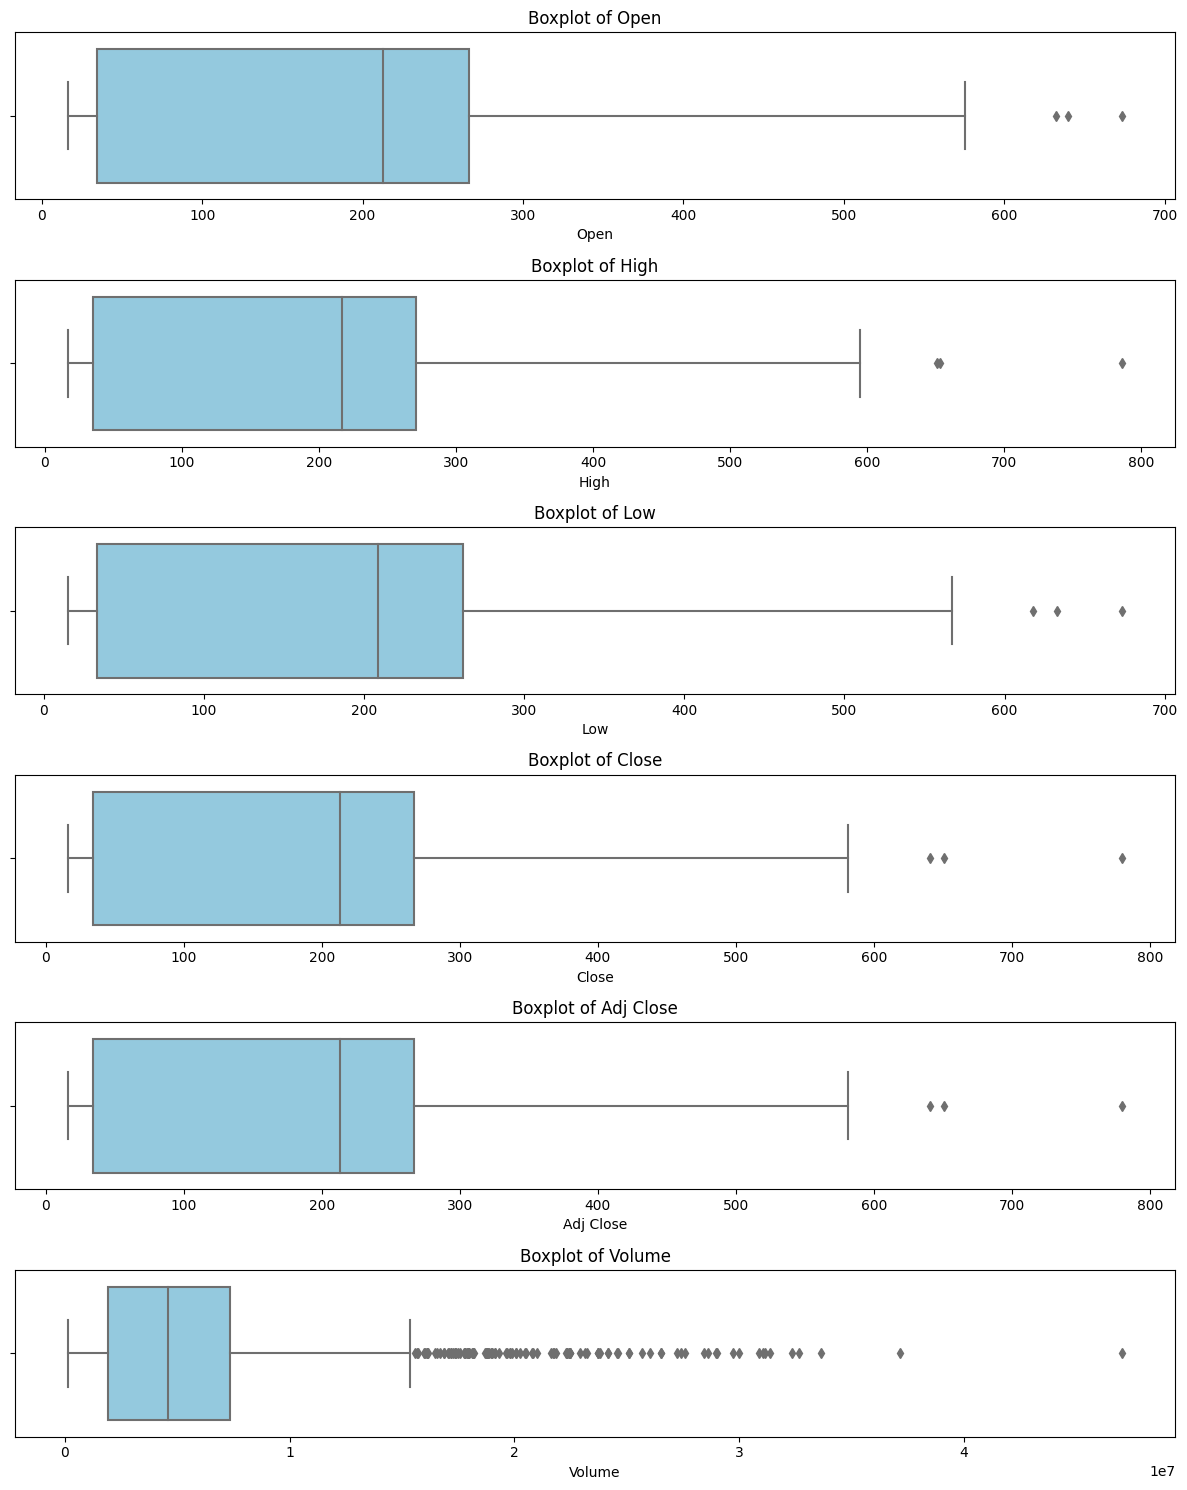

In [11]:
fig, axes = plt.subplots(len(cols), 1, figsize=(12,15))
for i, col in enumerate(cols):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


# **Remove extreme outliers using Z-score**

In [12]:
df_clean = df[(np.abs(stats.zscore(df[cols])) < 3).all(axis=1)].reset_index(drop=True)

print("Shape before outlier removal:", df.shape)
print("Shape after outlier removal:", df_clean.shape)


Shape before outlier removal: (2416, 7)
Shape after outlier removal: (2359, 7)


# **Time-based Features**

In [13]:
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Weekday'] = df_clean['Date'].dt.day_name()

# **Yearly Trends**

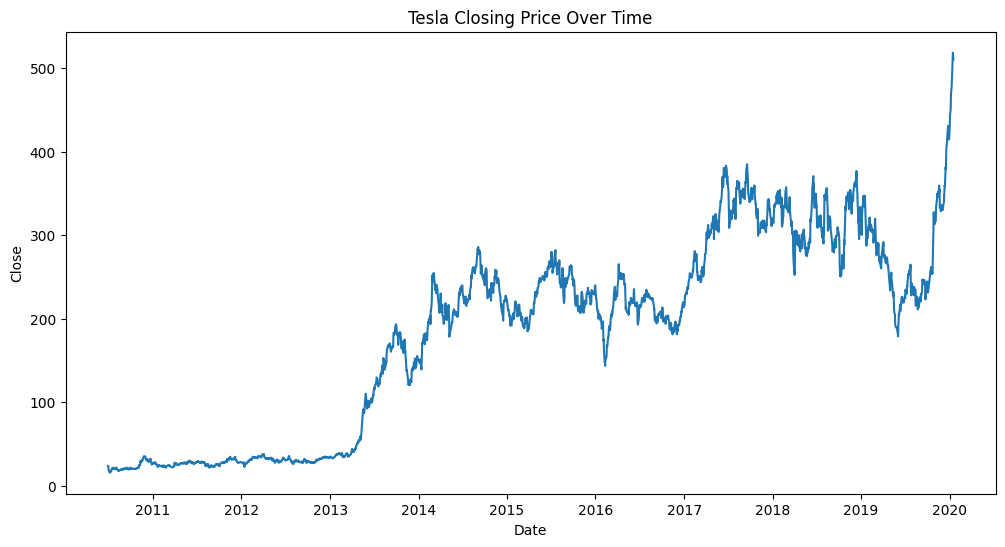

In [14]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_clean, x="Date", y="Close")
plt.title("Tesla Closing Price Over Time")
plt.show()

# **Volume Traded by Weekday**

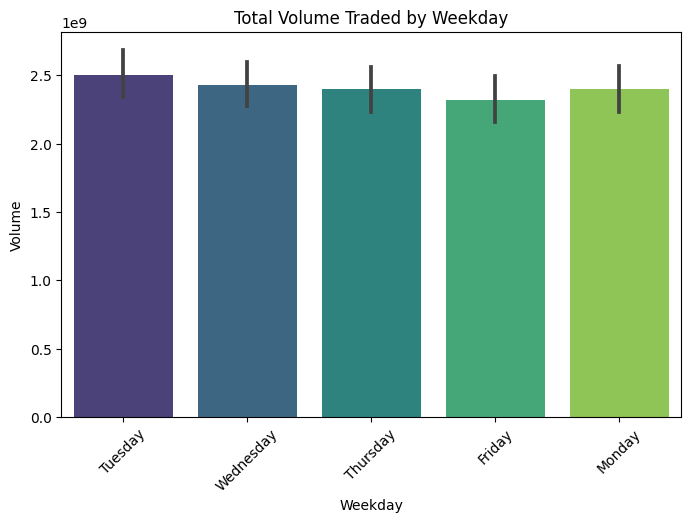

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_clean, x="Weekday", y="Volume", estimator=sum, palette="viridis")
plt.title("Total Volume Traded by Weekday")
plt.xticks(rotation=45)
plt.show()

# **Plot Closing Price**

In [16]:
df.set_index("Date", inplace=True)

In [17]:
ts = df['Close']


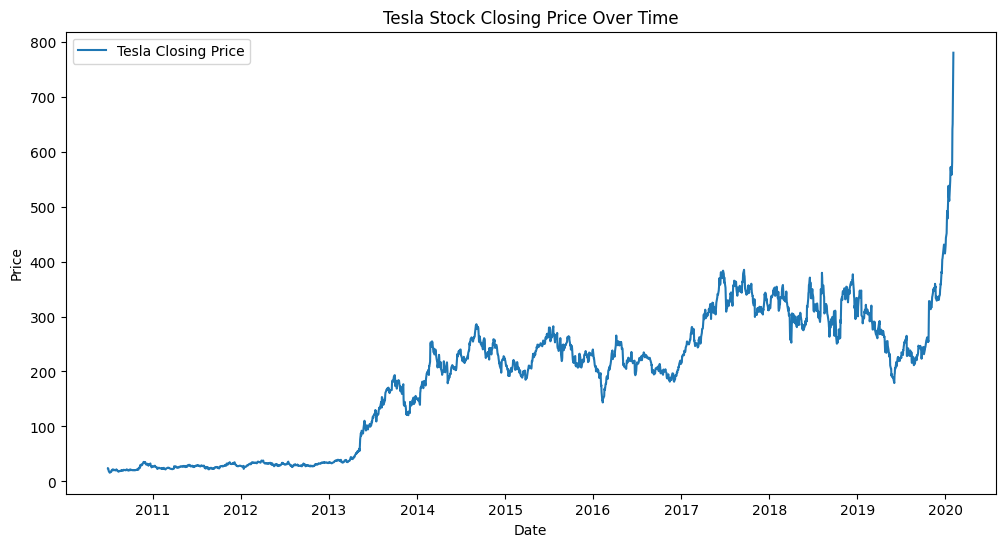

In [18]:

plt.figure(figsize=(12,6))
plt.plot(ts, label="Tesla Closing Price")
plt.title("Tesla Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# **ARIMA Model**

In [19]:


#  Train-test split
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

#  Define ranges for grid search (smaller for speed)
p = range(0, 4)   # AR terms
d = range(0, 3)   # differencing
q = range(0, 4)   # MA terms
pdq = list(itertools.product(p, d, q))

#  Rolling window grid search (optimized)
best_rmse = float("inf")
best_order = None

for order in pdq:
    try:
        history = train.tolist()  # start with initial training set
        predictions = []

        # Fit model only once per order on the initial train set
        model = ARIMA(history, order=order)
        model_fit = model.fit()

        for t in range(len(test)):
            # Forecast 1 step ahead
            yhat = model_fit.forecast(steps=1)[0]
            predictions.append(yhat)
            
            # Update history with actual value
            history.append(test[t])

            # Re-fit ARIMA every K steps instead of every step (optional)
            # This keeps rolling window but saves time
            if (t + 1) % 10 == 0:  # Refit every 10 steps
                model = ARIMA(history, order=order)
                model_fit = model.fit()

        rmse = np.sqrt(mean_squared_error(test, predictions))
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order

    except:
        continue

print("Best ARIMA order (rolling window):", best_order)
print("Best RMSE from rolling window grid search:", best_rmse)

#  Final rolling window forecast with best order
history = train.tolist()
predictions = []
model = ARIMA(history, order=best_order)
model_fit = model.fit()

for t in range(len(test)):
    yhat = model_fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(test[t])

    if (t + 1) % 10 == 0:
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()

rmse_arima_best = np.sqrt(mean_squared_error(test, predictions))
mape_arima_best = mean_absolute_percentage_error(test, predictions)

print("ARIMA RMSE (rolling window):", rmse_arima_best)
print("ARIMA MAPE (rolling window):", mape_arima_best)


Train size: 1932
Test size: 484
Best ARIMA order (rolling window): (3, 0, 2)
Best RMSE from rolling window grid search: 26.648458701687428
ARIMA RMSE (rolling window): 26.648458701687428
ARIMA MAPE (rolling window): 0.05937251844828457


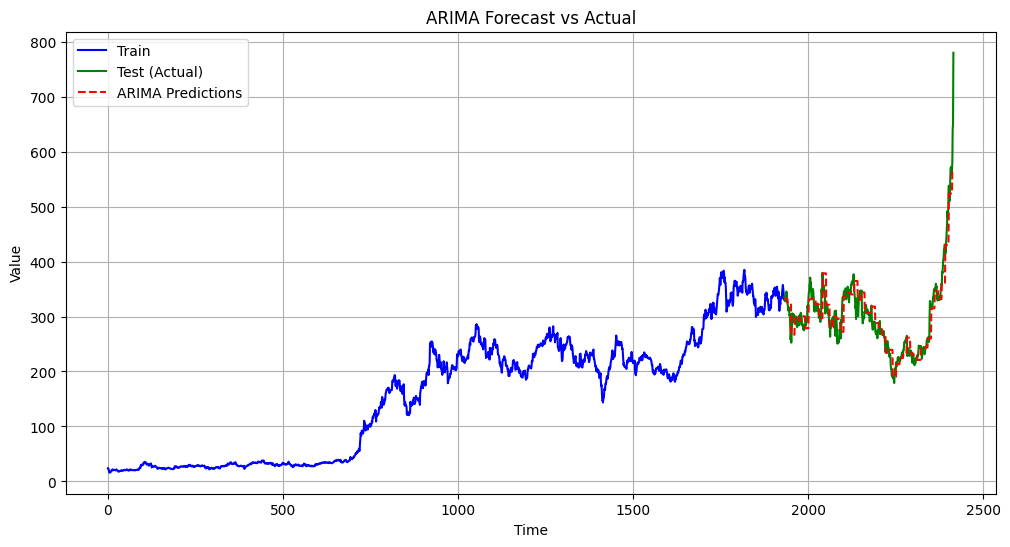

In [20]:
import matplotlib.pyplot as plt

train_size = int(len(ts) * 0.8)

plt.figure(figsize=(12,6))
plt.plot(range(train_size), ts[:train_size], label='Train', color='blue')
plt.plot(range(train_size, len(ts)), ts[train_size:], label='Test (Actual)', color='green')
plt.plot(range(train_size, len(ts)), predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


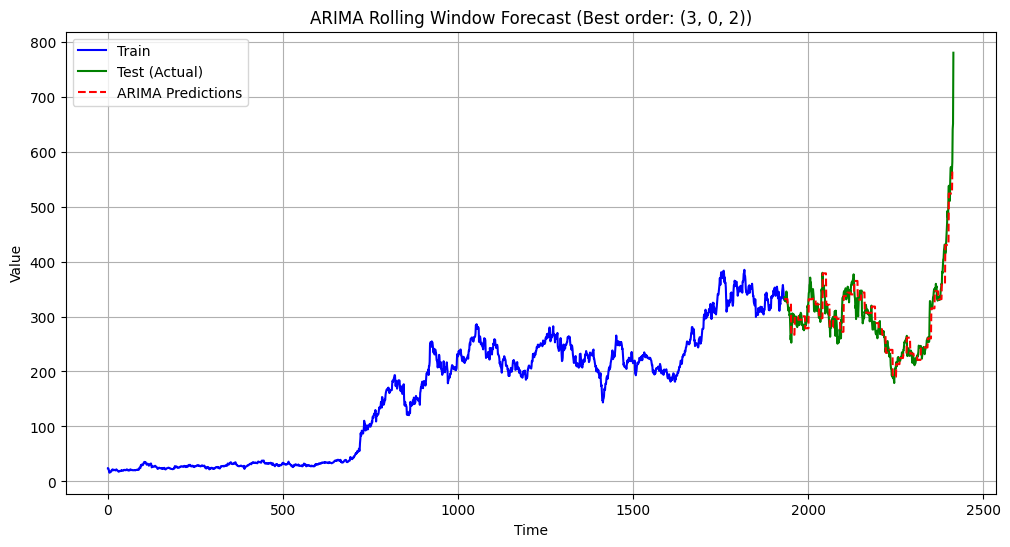

In [21]:

plt.figure(figsize=(12,6))
plt.plot(range(len(train)), train, label='Train', color='blue')
plt.plot(range(len(train), len(ts)), test, label='Test (Actual)', color='green')
plt.plot(range(len(train), len(ts)), predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title(f"ARIMA Rolling Window Forecast (Best order: {best_order})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# **LSTM**

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow import keras

# ---------- Normalize data ----------
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))

time_steps = 60

# ---------- Prepare training sequences ----------
X_train_seq = ts_scaled[:int(len(ts_scaled)*0.8)]
y_train_seq = ts_scaled[:int(len(ts_scaled)*0.8)]

# Build LSTM model (same as before)
model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=(time_steps,1)),
    keras.layers.LSTM(50, return_sequences=False),
    keras.layers.Dense(25),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare sequences for initial training
def create_sequences(data, time_steps=time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(ts_scaled[:int(len(ts_scaled)*0.8)], time_steps)
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

# ---------- Rolling window / walk-forward forecasting ----------
test_scaled = ts_scaled[int(len(ts_scaled)*0.8):]
history = ts_scaled[:int(len(ts_scaled)*0.8)].tolist()  # initial history
predictions = []

for i in range(len(test_scaled)):
    # Prepare input sequence
    input_seq = np.array(history[-time_steps:]).reshape(1, time_steps, 1)
    yhat = model.predict(input_seq, verbose=0)[0,0]
    predictions.append(yhat)
    history.append(test_scaled[i])  # append actual value for next step

# ---------- Rescale predictions back to original scale ----------
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
y_test_inv = scaler.inverse_transform(test_scaled)

# ---------- Evaluate ----------
rmse_lstm_rw = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mape_lstm_rw = mean_absolute_percentage_error(y_test_inv, predictions_inv)

print("LSTM RMSE (rolling window):", rmse_lstm_rw)
print("LSTM MAPE (rolling window):", mape_lstm_rw)


I0000 00:00:1759550696.590833      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759550696.591514      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1759550701.379652     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0133
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6747e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5276e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3075e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3032e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9692e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9032e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8284e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9504e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9015e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6582e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6198e-04
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7687e-04
Epoch 14/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6858e-04
Epoch 15/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8

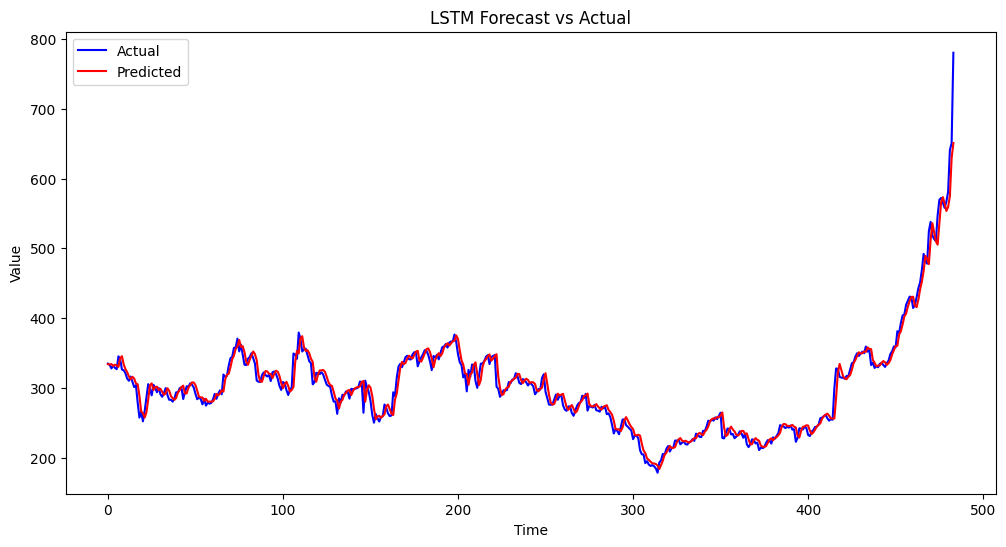

In [23]:
import matplotlib.pyplot as plt

# ---------- Plot Actual vs Predicted ----------
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(predictions_inv, label='Predicted', color='red')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


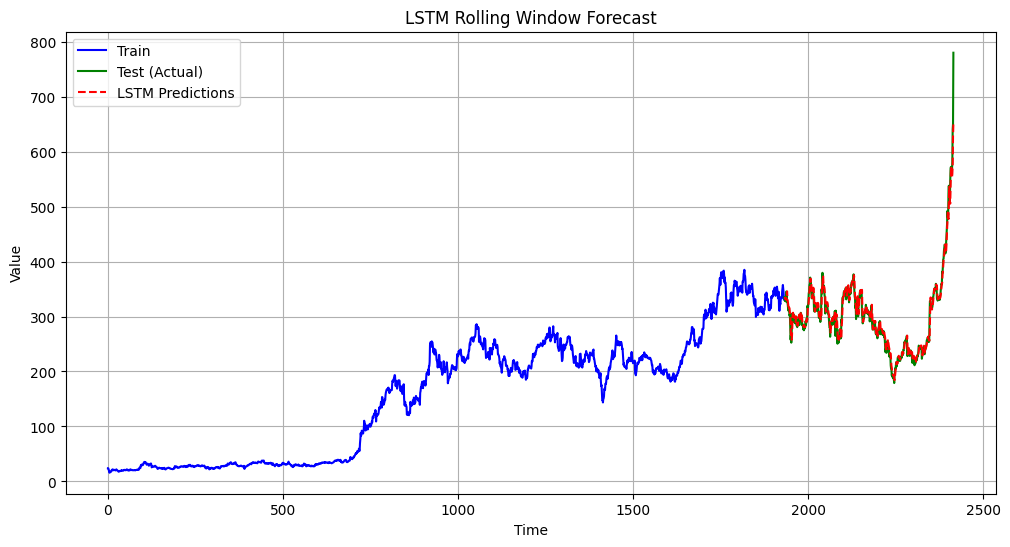

In [24]:
train_size = int(len(ts_scaled)*0.8)

plt.figure(figsize=(12,6))
plt.plot(range(train_size), scaler.inverse_transform(ts_scaled[:train_size]), label='Train', color='blue')
plt.plot(range(train_size, len(ts_scaled)), y_test_inv, label='Test (Actual)', color='green')
plt.plot(range(train_size, len(ts_scaled)), predictions_inv, label='LSTM Predictions', color='red', linestyle='--')
plt.title("LSTM Rolling Window Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


# **Comparison Table**

In [25]:
import pandas as pd

results = {
    "Model": ["ARIMA (Rolling Window)", "LSTM (Rolling Window)"],
    "RMSE": [rmse_arima_best, rmse_lstm_rw],
    "MAPE": [mape_arima_best, mape_lstm_rw]
}

comparison_df = pd.DataFrame(results)
print(comparison_df)


                    Model       RMSE      MAPE
0  ARIMA (Rolling Window)  26.648459  0.059373
1   LSTM (Rolling Window)  13.063411  0.026674


# **plot**

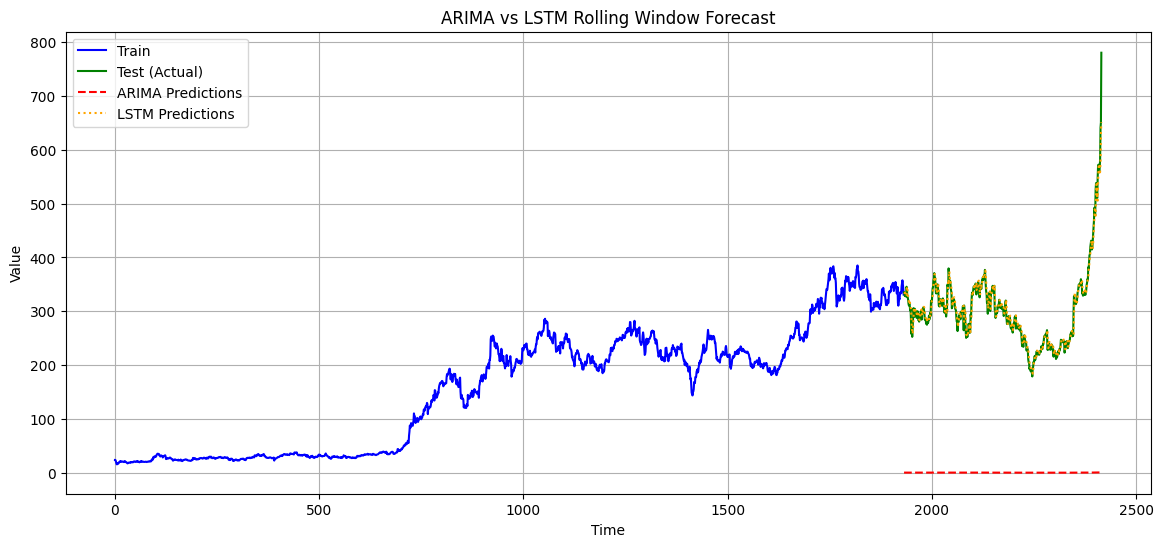

In [26]:
import matplotlib.pyplot as plt

train_size = int(len(ts) * 0.8)

plt.figure(figsize=(14,6))
plt.plot(range(train_size), ts[:train_size], label='Train', color='blue')
plt.plot(range(train_size, len(ts)), ts[train_size:], label='Test (Actual)', color='green')
plt.plot(range(train_size, len(ts)), predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.plot(range(train_size, len(ts)), predictions_inv, label='LSTM Predictions', color='orange', linestyle=':')
plt.title("ARIMA vs LSTM Rolling Window Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()